# 3D classification example based on DenseNet

This tutorial shows an example of 3D classification task based on DenseNet and array format transforms.

Here, the task is given to classify MR images into male/female.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_classification/torch/densenet_training_array.ipynb)

## Setup environment

In [4]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"


## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
torch.cuda.empty_cache()
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    AddChannel,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    EnsureType
)
import pickle
import time

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.8.1+253.ge8d2d4f4
Numpy version: 1.22.3
Pytorch version: 1.12.0a0+bd13bc6
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: e8d2d4f4018217347dc41b8b87eb13bfe75bf3be
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.19.1
mlflow version: 1.25.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# set this in your environment or previous cell to wherever IXI is downloaded and extracted
modelName = 'DenseNet264_40'
RunFolder = os.path.join("/HippoDense/", modelName)
DatasetDir = "/Datasets/01_P_Classification_all_hippo"
labels = []
images = []
NotFitImages = []
for root, dirs, files in os.walk(os.path.abspath(DatasetDir)):
    for file in files:
        # if file.split("_")[-3] == "L":
        #     labels.append(2)
        #     images.append(os.path.join(root, file))
        # elif file.split("_")[-3] == "E":
        #     labels.append(1)
        #     images.append(os.path.join(root, file))
        if file.split("_")[-2] == "Normal":
            labels.append(0)
            images.append(os.path.join(root, file))
        elif file.split("_")[-2] == "Dementia":
            labels.append(1)
            images.append(os.path.join(root, file))
        else:
            NotFitImages.append(file)
            # print(file)
print("{}: images cannot be used.".format(len(NotFitImages)))
# # labels = np.load(
#     '/workspace/monai/MONAI-tutorials/3d_classification/01_P_Classification_all_labels.npy')
NumClasses = len(np.unique(labels))
# ClassLabels = np.array(Labels)
if len(images)==len(labels):
    print("{}: total images prepared with {} different classes".format(len(images), NumClasses))

# 2 binary labels for gender classification: man or woman
# labels = np.array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])

# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

115: images cannot be used.
251: total images prepared with 2 different classes


In [3]:
# Define transforms
train_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), RandRotate90(), EnsureType()])

val_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), EnsureType()])

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[:200], labels=labels[:200], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[200:], labels=labels[200:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=4, num_workers=4, pin_memory=pin_memory)

<class 'torch.Tensor'> torch.Size([3, 1, 96, 96, 96]) tensor([[1., 0.],
        [0., 1.],
        [1., 0.]]) torch.Size([3, 2])


In [4]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet264(spatial_dims=3, in_channels=1, out_channels=2, growth_rate = 40).to(device)

loss_function = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

writer = SummaryWriter(modelName)
max_epochs = 150

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            modelPickle = os.path.join(RunFolder, modelName + time.strftime("_%Y%m%d_%H%M%S") + '.pickle')
            if not os.path.exists(RunFolder):
                os.makedirs(RunFolder)
            
            with open(modelPickle, 'wb') as f:
                pickle.dump(model, f)
            print("saved new best metric model = {}".format(modelPickle))

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/150
1/50, train_loss: 0.9323
2/50, train_loss: 0.6425
3/50, train_loss: 0.4463
4/50, train_loss: 0.5270
5/50, train_loss: 0.5175
6/50, train_loss: 0.2444
7/50, train_loss: 0.2119
8/50, train_loss: 0.2133
9/50, train_loss: 0.6898
10/50, train_loss: 0.0892
11/50, train_loss: 1.3808
12/50, train_loss: 0.0828
13/50, train_loss: 0.6387
14/50, train_loss: 0.5751
15/50, train_loss: 0.1283
16/50, train_loss: 0.7756
17/50, train_loss: 0.1414
18/50, train_loss: 1.2284
19/50, train_loss: 0.1582
20/50, train_loss: 0.1692
21/50, train_loss: 1.0586
22/50, train_loss: 0.7057
23/50, train_loss: 0.5875
24/50, train_loss: 0.5113
25/50, train_loss: 0.2695
26/50, train_loss: 0.2885
27/50, train_loss: 0.2481
28/50, train_loss: 0.6684
29/50, train_loss: 1.3814
30/50, train_loss: 1.0148
31/50, train_loss: 0.2614
32/50, train_loss: 0.2595
33/50, train_loss: 0.2737
34/50, train_loss: 0.5485
35/50, train_loss: 0.2366
36/50, train_loss: 0.4949
37/50, train_loss: 0.5178
38/50, train_loss: 0.194

positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.


saved new best metric model = /HippoDense/DenseNet264_40/DenseNet264_40_20220524_043402.pickle
Current epoch: 2 current accuracy: 0.9216 
Best accuracy: 0.9216 at epoch 2
----------
epoch 3/150
1/50, train_loss: 0.1759
2/50, train_loss: 0.5941
3/50, train_loss: 0.2059
4/50, train_loss: 0.4950
5/50, train_loss: 0.5334
6/50, train_loss: 0.2123
7/50, train_loss: 0.6369
8/50, train_loss: 0.4802
9/50, train_loss: 0.2023
10/50, train_loss: 0.9130
11/50, train_loss: 1.0121
12/50, train_loss: 0.4758
13/50, train_loss: 0.3438
14/50, train_loss: 0.2998
15/50, train_loss: 0.2706
16/50, train_loss: 0.9978
17/50, train_loss: 0.2541
18/50, train_loss: 0.2189
19/50, train_loss: 0.1797
20/50, train_loss: 0.6606
21/50, train_loss: 0.1610
22/50, train_loss: 0.6345
23/50, train_loss: 0.5725
24/50, train_loss: 0.0990
25/50, train_loss: 1.3363
26/50, train_loss: 0.6698
27/50, train_loss: 0.5872
28/50, train_loss: 0.1378
29/50, train_loss: 0.1524
30/50, train_loss: 0.5685
31/50, train_loss: 0.1638
32/50, tr

# Occlusion sensitivity
One method for trying to visualise why the network made a given prediction is occlusion sensitivity. We occlude part of the image, and see how the probability of a given prediction changes. We then iterate over the image, moving the occluded portion as we go, and in doing so we build up a sensitivity map detailing which areas were the most important in making the decision.

#### Bounds
If we were to test the occlusion centred on all voxels in our image, we would have to do `torch.prod(im.shape) = 96^3 = ~1e6` predictions. We can use the bounding box to only to the estimations in a region of interest, for example over one slice.

To do this, we simply give the bounding box as `(minC,maxC,minD,maxD,minH,maxH,minW,maxW)`. We can use `-1` for any value to use its full extent (`0` and `im.shape-1` for min's and max's, respectively).

#### Output
The output image in this example will look fairly bad, since our network hasn't been trained for very long. Training for longer should improve the quality of the occlusion map.

In [10]:
# create a validation data loader
test_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [11]:
# Get a random image and its corresponding label
img, label = get_next_im()

Computing occlusion sensitivity: 100%|██████████| 64/64 [00:00<00:00, 423.74it/s]


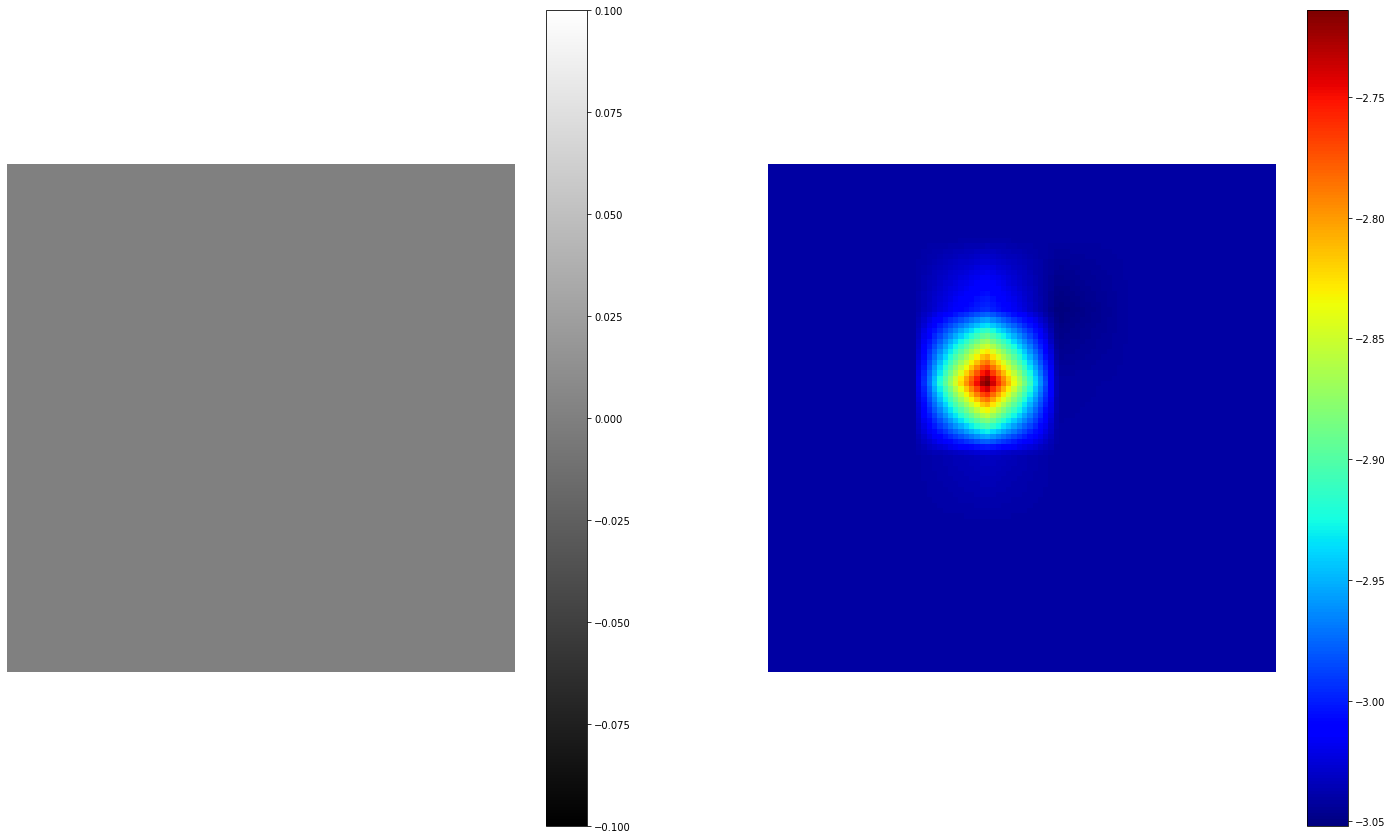

In [12]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10, stride=12)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[..., label.argmax().item()]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

## Cleanup data directory

Remove directory if a temporary was used.

In [11]:
if directory is None:
    shutil.rmtree(root_dir)